# Hybrid model for energy demand in France

First predict demand using only climate variables.
Then, train a model on the predictions using non-climate stuff like weekends, month etc.

In [118]:
import os
import glob
import xarray as xr
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error
from sklearn.inspection import permutation_importance

from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy.stats import pearsonr, randint, uniform
from scipy.spatial.distance import correlation

import matplotlib.pyplot as plt

### Note:

You will need to change the kernel to ml_env to use `mlxtend`

In [119]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [120]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [121]:
path = "/g/data/w42/dr6273/work/projects/Aus_energy/"

In [122]:
region = "FR"

### Demand

In [123]:
demand = pd.read_csv(
    "/g/data/w42/dr6273/work/data/ENTSOE/ENTSOE_daily_demand_2006-2018.csv",
    index_col=0,
    parse_dates=True
)

In [124]:
demand = demand[demand["Country"] == region]["Power (MWh/day)"]

In [125]:
dem_da = xr.DataArray(
    demand.squeeze(),
    dims=["time"],
    coords={"time": demand.index.values}
)

In [126]:
dem_da = dem_da.expand_dims({"region": [region]})

In [127]:
dem_da = fn.detrend_dim(dem_da, "time") + dem_da.mean("time")

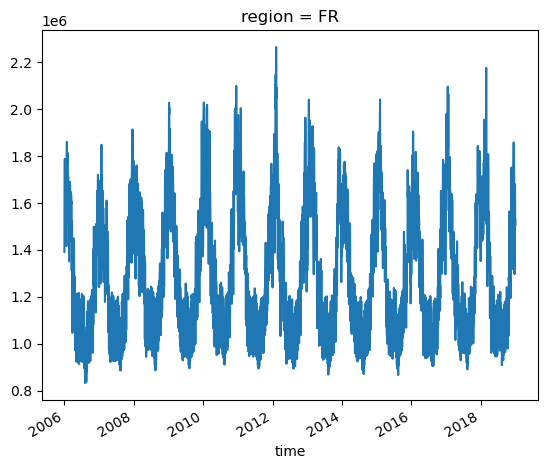

In [128]:
dem_da.plot()

### Predictors

In [129]:
files = fn.get_predictor_files(region, "pop_dens_mask")

In [130]:
pred_ds = xr.open_mfdataset(files, combine="nested", compat="override").compute()

In [131]:
pred_ds.data_vars

Data variables:
    msdwswrf  (time) float64 44.56 43.21 51.47 53.18 ... 31.66 34.83 29.22 37.78
    w10       (time) float64 4.219 4.438 3.654 3.395 ... 4.548 4.841 4.735 4.957
    t2m       (time) float64 279.4 278.4 277.2 275.8 ... 279.8 280.6 281.0 283.6
    cdd       (time) float64 0.02074 0.02073 0.02073 ... -0.02073 -0.02074
    hdd       (time) float64 8.808 9.803 11.03 12.42 ... 8.312 7.498 7.14 4.48
    rh        (time) float64 83.3 82.79 82.81 81.51 ... 85.94 82.65 86.8 81.35
    t2min     (time) float64 nan 275.6 274.4 272.7 ... 276.8 277.7 277.4 280.6
    mtpr      (time) float64 2.423e-05 5.883e-05 ... 4.854e-05 5.122e-05
    q         (time) float64 5.097 4.794 4.397 3.954 ... 5.48 5.54 5.976 6.661
    t2max     (time) float64 nan 280.8 279.0 278.0 ... 282.4 282.6 283.8 285.9

In [132]:
pred_ds = pred_ds.expand_dims({"region": [region]})

## Prepare data

In [137]:
time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df

In [138]:
region_dfs[region]

,demand,msdwswrf,w10,t2m,cdd,hdd,rh,t2min,mtpr,q,t2max
2006-01-01,1.390770e+06,33.469701,2.968107,277.120854,-0.009722,11.013986,87.793425,274.126953,0.000044,4.606783,278.299142
2006-01-02,1.558161e+06,38.620781,2.234833,276.025270,-0.009723,12.109568,88.337877,272.778723,0.000021,4.223533,277.842970
2006-01-03,1.680000e+06,38.505117,1.849658,275.761280,-0.009725,12.373554,87.220708,272.670548,0.000014,4.090290,277.582042
2006-01-04,1.723594e+06,40.630597,2.490590,274.708175,-0.009727,13.426657,86.078723,271.983277,0.000009,3.725595,276.859842
2006-01-05,1.787870e+06,38.203008,2.962313,274.200237,-0.009729,13.934592,84.712166,271.639411,0.000008,3.543822,276.056212
...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,1.679940e+06,40.692448,1.612725,275.848274,-0.018136,12.273452,87.795194,273.492140,0.000002,4.168545,279.485340
2018-12-28,1.669453e+06,38.997165,1.929787,276.401266,-0.018138,11.720458,89.504321,273.725989,0.000002,4.416365,279.349883
2018-12-29,1.591212e+06,36.062917,3.070928,277.571661,-0.018140,10.550060,88.539303,274.841585,0.000012,4.729524,280.415372
2018-12-30,1.501771e+06,36.289060,3.001991,278.441629,-0.018142,9.680090,86.732386,275.520617,0.000011,4.884352,280.783025


## Split data into training and testing

Using this as a guide: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

As this is time series data, leave out the last two years for testing.

In [139]:
first_train_year = 2006
last_train_year = 2015

In [140]:
first_test_year = 2016
last_test_year = 2018

In [141]:
# Hold out last two years for testing
test_len = dem_da.sel(time=slice(str(first_test_year), str(last_test_year))).time.values.shape[0]

In [142]:
test_len

1096

In [143]:
train_X, test_X, train_y, test_y = fn.split(
    region_dfs[region],
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

## Sequential feature selection

Chooses the predictors using forwards selection and a stopping criterion for a score.

In [144]:
# rf = RandomForestRegressor(
#     n_estimators=best_params["n_estimators"],
#     random_state=0
# )

In [145]:
rf = ExtraTreesRegressor(
    random_state=0
)

In [146]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2015 2015 2015]


In [147]:
model = fn.mlextend_sfs(train_X, train_y, rf, list(logo), True, scoring="neg_mean_absolute_error")

In [148]:
model.subsets_

{1: {'feature_idx': (4,),
  'cv_scores': array([-114532.48831486, -109327.53517329, -112739.15683306,
         -108446.70199371, -111958.37787992, -101238.64847643,
         -111198.61302535, -111317.6731199 , -101003.4308561 ,
         -110236.81519074]),
  'avg_score': -109199.9440863359,
  'feature_names': ('4',)},
 2: {'feature_idx': (0, 4),
  'cv_scores': array([ -92343.70451719,  -86249.91085122,  -97982.87782484,
          -94605.70282249,  -94391.20628861,  -97755.99528309,
         -104443.18635829,  -94049.5393483 ,  -91320.15721986,
          -90711.96332161]),
  'avg_score': -94385.4243835491,
  'feature_names': ('0', '4')},
 3: {'feature_idx': (0, 3, 4),
  'cv_scores': array([ -86726.60539149,  -86342.58978134,  -95534.40412268,
          -87963.87164861,  -91713.14945299,  -91364.1391391 ,
         -101577.44494624,  -87571.25301961,  -83738.77711363,
          -84277.9555697 ]),
  'avg_score': -89681.01901853971,
  'feature_names': ('0', '3', '4')},
 4: {'feature_idx': (

In [149]:
model.k_feature_idx_

(0, 1, 3, 4, 5, 6, 7, 8, 9)

In [150]:
# selected_features = list(region_dfs["EU"].columns[1:][model.get_support()])
# print(selected_features)

In [151]:
selected_features = list(region_dfs[region].columns[1:][list(model.k_feature_idx_)])
print(selected_features)

['msdwswrf', 'w10', 'cdd', 'hdd', 'rh', 't2min', 'mtpr', 'q', 't2max']


In [152]:
pd.DataFrame.from_dict(model.get_metric_dict()).T

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4,)","[-114532.48831485979, -109327.53517329044, -11...",-109199.944086,"(4,)",3231.221985,4350.566369,1450.18879
2,"(0, 4)","[-92343.70451718553, -86249.91085122233, -9798...",-94385.424384,"(0, 4)",3474.656546,4678.33036,1559.443453
3,"(0, 3, 4)","[-86726.60539149336, -86342.58978134359, -9553...",-89681.019019,"(0, 3, 4)",3891.463094,5239.525029,1746.508343
4,"(0, 3, 4, 7)","[-84732.25357706992, -84614.02891867598, -9254...",-88185.469566,"(0, 3, 4, 7)",4125.519461,5554.662076,1851.554025
5,"(0, 3, 4, 6, 7)","[-86581.5653553532, -84916.97588356162, -91891...",-87573.467331,"(0, 3, 4, 6, 7)",3737.471902,5032.188949,1677.396316
6,"(0, 1, 3, 4, 6, 7)","[-84888.40378668216, -83397.74058559437, -9203...",-86745.367646,"(0, 1, 3, 4, 6, 7)",3244.132782,4367.949662,1455.983221
7,"(0, 1, 3, 4, 5, 6, 7)","[-85912.9235176075, -82972.56772981155, -92283...",-86711.466922,"(0, 1, 3, 4, 5, 6, 7)",3252.082133,4378.652789,1459.55093
8,"(0, 1, 3, 4, 5, 6, 7, 9)","[-86102.3305584105, -84102.79904207324, -91715...",-86739.471102,"(0, 1, 3, 4, 5, 6, 7, 9)",3573.792348,4811.80831,1603.936103
9,"(0, 1, 3, 4, 5, 6, 7, 8, 9)","[-86350.44049867541, -84176.18108733854, -9122...",-86548.437532,"(0, 1, 3, 4, 5, 6, 7, 8, 9)",3463.679316,4663.550451,1554.516817
10,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)","[-85356.4246349162, -84610.8370642531, -91579....",-87146.67735,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)",3279.416063,4415.455608,1471.818536


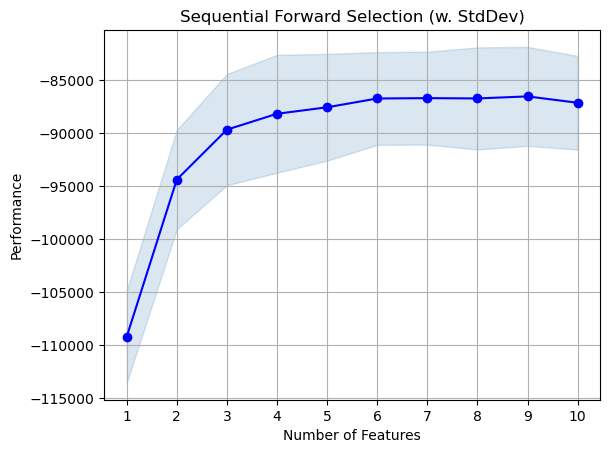

In [153]:
fig1 = plot_sfs(model.get_metric_dict(), kind='std_dev')
# plt.ylim([0.8, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

## Tune hyperparameters

Using leave one group out cross validation, where a group is a year.

In [154]:
parameters = {
    "n_estimators": randint(200, 500), # no. trees in the forest
    "min_samples_leaf": randint(5, 30), # min no. samples at leaf node
    "max_depth" : randint(5, 50), # max depth of each tree
    # "max_features" : uniform(0.2, 1) # max proportion of features to consider at split
    "max_leaf_nodes": randint(20, 100) # size of tree, how many end nodes
}

In [155]:
retain = ["demand"] + selected_features

In [156]:
final_features = region_dfs[region][retain]

In [157]:
final_features.head()

,demand,msdwswrf,w10,cdd,hdd,rh,t2min,mtpr,q,t2max
2006-01-01,1.390770e+06,33.469701,2.968107,-0.009722,11.013986,87.793425,274.126953,0.000044,4.606783,278.299142
2006-01-02,1.558161e+06,38.620781,2.234833,-0.009723,12.109568,88.337877,272.778723,0.000021,4.223533,277.842970
2006-01-03,1.680000e+06,38.505117,1.849658,-0.009725,12.373554,87.220708,272.670548,0.000014,4.090290,277.582042
2006-01-04,1.723594e+06,40.630597,2.490590,-0.009727,13.426657,86.078723,271.983277,0.000009,3.725595,276.859842
2006-01-05,1.787870e+06,38.203008,2.962313,-0.009729,13.934592,84.712166,271.639411,0.000008,3.543822,276.056212


In [158]:
train_X, test_X, train_y, test_y = fn.split(
    final_features,
    "demand",
    test_size=test_len,
    random_state=0,
    shuffle=False
)

In [159]:
# # very restricted space for testing
# parameters = {
#     "n_estimators": randint(10, 12), # no. trees in the forest
# }

In [160]:
rf = ExtraTreesRegressor()

In [161]:
logo = fn.leave_one_group_out(train_X, train_y, dem_da, str(first_train_year), str(last_train_year))

[2006 2006 2006 ... 2015 2015 2015]


In [162]:
%%time
best_params = fn.tune_hyperparameters(
    train_X,
    train_y,
    rf,
    parameters,
    logo,
    n_iter=200
)

CPU times: user 23min 15s, sys: 2.18 s, total: 23min 17s
Wall time: 23min 17s


In [163]:
best_params

{'max_depth': 29,
 'max_leaf_nodes': 99,
 'min_samples_leaf': 14,
 'n_estimators': 474}

## Finalise model

In [164]:
rf = ExtraTreesRegressor(
    n_estimators=best_params["n_estimators"],
    min_samples_leaf=best_params["min_samples_leaf"],
    max_depth=best_params["max_depth"],
    max_leaf_nodes=best_params["max_leaf_nodes"],
    random_state=0,
)

In [165]:
model_train, pred_train = fn.predict_forest(train_y, train_X, train_X, rf)

In [166]:
model_test, pred_test = fn.predict_forest(train_y, train_X, test_X, rf)

In [167]:
pred_train.shape

(3652,)

In [168]:
pred_test.shape

(1096,)

## Evaluate performance

In [169]:
metric_names = ["R2", "MAE", "MSE", "MAPE", "MedAE"]
metrics = [r2_score, mean_absolute_error,
           mean_squared_error, mean_absolute_percentage_error, median_absolute_error]

In [170]:
train_scores = fn.compute_scores(train_y, pred_train, metrics)

In [171]:
train_scores

[0.8713156018283824,
 79257.25712077902,
 8849137930.964724,
 0.06342558161281277,
 70518.59447902767]

In [172]:
test_scores = fn.compute_scores(test_y, pred_test, metrics)

In [173]:
test_scores

[0.8759492568984236,
 79564.11327644002,
 8764771441.934954,
 0.06258554960268892,
 72942.6009472966]

In [174]:
def plot_scores(train, test, metric_names):
    """
    Subplot for each metric showing score for train and test.
    """
    fig, ax = plt.subplots(2, 3, figsize=(10, 6))
    for i, a in enumerate(ax.flatten()):
        if i < len(metric_names):
            a.bar(["Train", "Test"], [train[i], test[i]])
            a.set_title(metric_names[i])
    plt.tight_layout()

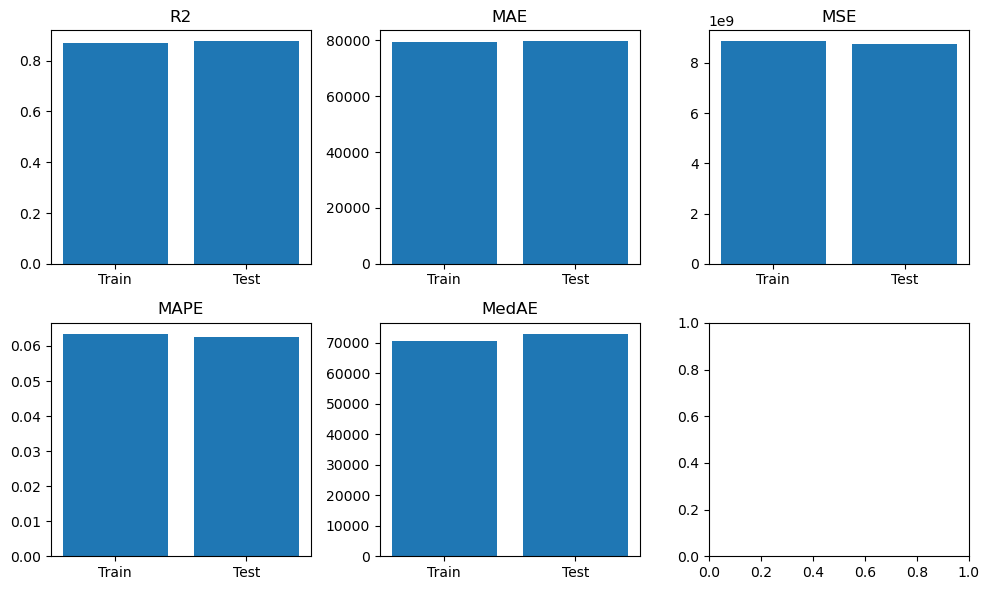

In [175]:
plot_scores(train_scores, test_scores, metric_names)

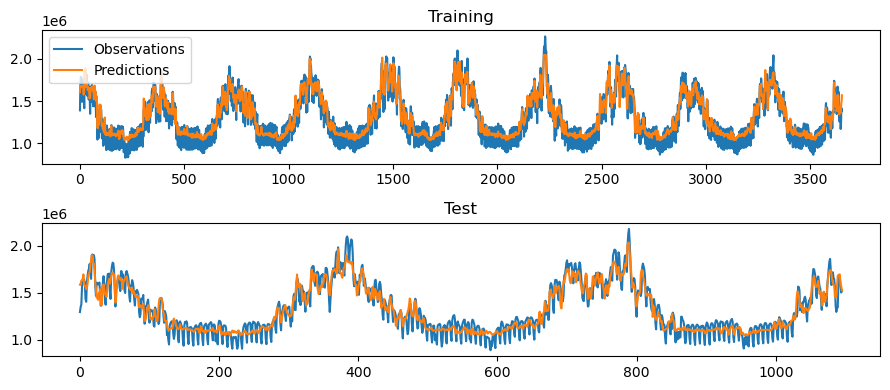

In [176]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

ax[0].plot(train_y, label="Observations")
ax[0].plot(pred_train, label="Predictions")
ax[0].legend()
ax[0].set_title("Training")

ax[1].plot(test_y)
ax[1].plot(pred_test)
ax[1].set_title("Test")

plt.tight_layout()

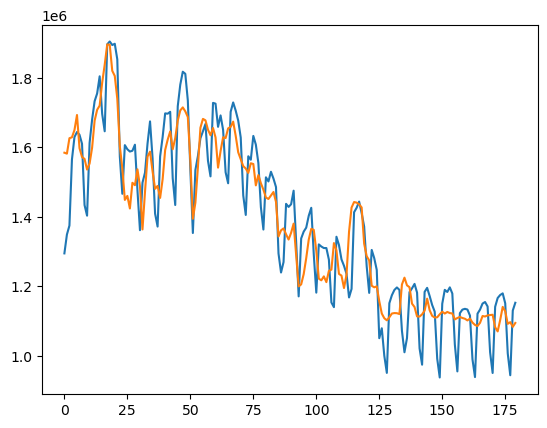

In [177]:
plt.plot(test_y[:180])
plt.plot(pred_test[:180])

## Permutation importances

Compute these on the training and test sets. Differences tell us what the model actually used to make the predictions.

In [178]:
perm_train = fn.perm_imp(
    model_train,
    train_X,
    train_y,
    n_repeats=2,
)

In [179]:
perm_test = fn.perm_imp(
    model_test,
    test_X,
    test_y,
    n_repeats=2,
)

In [180]:
perm_train

{'importances_mean': array([0.02900616, 0.00223407, 0.0110088 , 0.23796555, 0.0042617 ,
        0.06071413, 0.00303192, 0.01618525, 0.12360541]),
 'importances_std': array([1.47790835e-03, 9.06392792e-05, 8.76426879e-05, 5.82370667e-03,
        2.30791879e-04, 2.29512669e-03, 1.59263833e-04, 8.19301482e-04,
        3.96969531e-03]),
 'importances': array([[0.03048407, 0.02752825],
        [0.00214343, 0.00232471],
        [0.01092116, 0.01109644],
        [0.24378925, 0.23214184],
        [0.00449249, 0.00403091],
        [0.06300926, 0.058419  ],
        [0.00287265, 0.00319118],
        [0.01700455, 0.01536595],
        [0.12757511, 0.11963572]])}

In [181]:
perm_test

{'importances_mean': array([0.02616257, 0.00048286, 0.00709326, 0.24121278, 0.0023285 ,
        0.05776522, 0.00078778, 0.01627188, 0.12223336]),
 'importances_std': array([2.26284361e-03, 9.42218752e-06, 4.83018851e-04, 3.07772136e-03,
        7.37567288e-04, 3.86967609e-04, 1.61277020e-04, 8.25874350e-05,
        6.06459285e-04]),
 'importances': array([[0.02389972, 0.02842541],
        [0.00047343, 0.00049228],
        [0.00661024, 0.00757628],
        [0.2442905 , 0.23813506],
        [0.00159093, 0.00306607],
        [0.05815218, 0.05737825],
        [0.00094906, 0.00062651],
        [0.01635447, 0.01618929],
        [0.1216269 , 0.12283982]])}

In [182]:
fn.print_perm_imp(perm_train, selected_features)

hdd      0.238 +/- 0.006
t2max    0.124 +/- 0.004
t2min    0.061 +/- 0.002
msdwswrf 0.029 +/- 0.001
q        0.016 +/- 0.001
cdd      0.011 +/- 0.000
rh       0.004 +/- 0.000
mtpr     0.003 +/- 0.000
w10      0.002 +/- 0.000


In [183]:
fn.print_perm_imp(perm_test, selected_features)

hdd      0.241 +/- 0.003
t2max    0.122 +/- 0.001
t2min    0.058 +/- 0.000
msdwswrf 0.026 +/- 0.002
q        0.016 +/- 0.000
cdd      0.007 +/- 0.000
rh       0.002 +/- 0.001
mtpr     0.001 +/- 0.000
w10      0.000 +/- 0.000


# Non-weather model

In [53]:
# time_cols = ["is_weekend", "month_sin", "month_cos"]
# time_cols = ["is_weekend", "month_int"]
# time_cols = ["is_weekend", "season_int"]
# time_cols = ["is_weekend", "is_transition"]
time_cols = ["is_weekend"]
# time_cols = []

region_dfs = {}
for region in dem_da.region.values:
    df = fn.to_dataframe(dem_da, pred_ds, region)
    for t in time_cols:
        df = fn.add_time_column(df, t)
    new_cols = np.append(np.append("demand", time_cols), df.columns[:-(len(time_cols) + 1)])
    df = df[new_cols]
    region_dfs[region] = df